In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from typing import List
import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sys
import matplotlib.pyplot as plt
sys.path.append('..')

In [67]:
from src import train, utils
from src import calculus as calc
import src.data.aquarium_domain as aq
import src.models.mlp_model as mm

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
NU = 0.001
U_MAX = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
domain_ctx = aq.AquariumContext(
    dim=2,
    l_bounds=[0, 0],
    u_bounds=[2.2, 0.42],
    N_int=4_000,
    N_sides=[(100, 100), (100, 100)],
    device=device,
    ball_centre=torch.tensor([0.2, 0.2], device=device),
    ball_r=0.05
)

domain = aq.AquariumDomain(domain_ctx)
domain.generate_points()

In [71]:
#TODO: vymyslet lepsi system pro derivace


def loss_stream(model: torch.nn.Module, domain: aq.AquariumDomain) -> torch.Tensor:
    # ztrata na vnitrku
    psi, p, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y = calc.compute_derivatives_ns(model, domain.interior)
    inner_loss_1 = torch.mean((-NU * (u_xx + u_yy) + u * u_x + v * u_y + p_x)**2)
    inner_loss_2 = torch.mean((-NU * (v_xx + v_yy) + u * v_x + v * v_y + p_y)**2)
    inner_loss = inner_loss_1 + inner_loss_2

    # ztrata na leve hranici: x=0
    _, v_left, u_left = calc.compute_derivatives_2d(model, domain.sides[0][0], 0)

    inflow = 4 * U_MAX * domain.sides[0][0][:, 1:2] * (domain.ctx.u_bounds[1] - domain.sides[0][0][:, 1:2]) / (domain.ctx.u_bounds[1]**2)
    left_loss = torch.mean((u_left - inflow)**2 + v_left**2)

    # ztrata na prave hranici: x=2.2
    in_right = domain.sides[0][1].requires_grad_(True)
    out_right = model(in_right)
    psi_right, p_right = out_right[:, 0], out_right[:, 1]
    psi_right_grad = grad(psi_right, in_right, torch.ones_like(psi_right), create_graph=True)[0]
    v_right, u_right = -psi_right_grad[:, 0:1], psi_right_grad[:, 1:2]
    v_right_x = grad(v_right, in_right, torch.ones_like(v_right), create_graph=True)[0][:, 0:1]
    u_right_x = grad(u_right, in_right, torch.ones_like(u_right), create_graph=True)[0][:, 0:1]

    right_loss = torch.mean((NU * u_right_x - p_right)**2 + v_right_x**2)

    # ztrata na horni hranici: y=0.42
    sides = torch.cat([domain.sides[1][1], domain.sides[1][0], domain.ball_boundary], dim=0).requires_grad_(True)
    psi_sides = model(sides)[:, :-1]
    psi_sides_grad = grad(psi_sides, sides, torch.ones_like(psi_sides), create_graph=True)[0]
    side_loss = torch.mean(psi_sides_grad[:, 0:1]**2 + psi_sides_grad[:, 1:2]**2)
    
    return [inner_loss, left_loss, right_loss, side_loss]



In [72]:
def int_residuum(output: torch.Tensor, input: torch.Tensor) -> torch.Tensor:
    psi, p = output[:, :-1], output[:, -1:]
    u = grad(psi, input, torch.ones_like(psi), create_graph=True)[0]
    residuum = calc.material_derivative(input, u, device=device, time_dependant=True) +\
               calc.nabla(input, p, retain=True) - NU * calc.laplacian(input, u, device=device, time_dependant=False)
    return residuum


def continuity_residuum(output: torch.Tensor, input: torch.Tensor) -> torch.Tensor:
    u, v = output[:, 0:1], output[:, 1:2]
    u_x = grad(u, input, torch.ones_like(u), create_graph=True)[0][:, 0:1]
    v_y = grad(v, input, torch.ones_like(v), create_graph=True)[0][:, 1:2]
    return u_x + v_y


def loss_no_stream(model: torch.nn.Module, domain: aq.AquariumDomain) -> torch.Tensor:
    # ztrata na vnitrku
    pde_intput = domain.interior.requires_grad_(True)
    pde_output = model(pde_intput)
    pde_res = int_residuum(pde_output, pde_intput)
    inner_loss = torch.mean(pde_res[:, 0:1]**2 + pde_res[:, 1:2]**2)
    
    # ztrata na leve hranici
    input_left = domain.sides[0][0].requires_grad_(True)
    output_left = model(input_left)
    psi_left = output_left[:, :-1]
    u_left = grad(psi_left, input_left, torch.ones_like(psi_left), create_graph=True)[0]
    inflow = 4 * U_MAX * input_left[:, 1:2] * (domain.ctx.u_bounds[1] - input_left[:, 1:2]) / (domain.ctx.u_bounds[1]**2)
    left_loss = torch.mean((u_left[:, 0:1] - inflow)**2 + u_left[:, 1:2]**2)
    
    # ztrata na prave hranici
    input_right = domain.sides[0][1].requires_grad_(True)
    output_right = model(input_right)
    psi_right, p_right = output_right[:, :-1], output_right[:, -1:]
    u_right = grad(psi_right, input_right, torch.ones_like(psi_right), create_graph=True)[0]
    # print(u_right, p_right)
    u_right_x = grad(u_right[:, 0:1], input_right, torch.ones_like(u_right[:, 0:1]), create_graph=True)[0][:, 0:1]
    v_right_x = grad(u_right[:, 1:2], input_right, torch.ones_like(u_right[:, 1:2]), create_graph=True)[0][:, 0:1]
    right_loss = torch.mean((NU * u_right_x - p_right)**2 + v_right_x**2)
    # print(u_right_x, v_right_x)

    # ztrata na zbylych hranicich
    sides = torch.cat([domain.sides[1][1], domain.sides[1][0], domain.ball_boundary], dim=0).requires_grad_(True)
    psi_sides = model(sides)[:, :-1]
    u_sides = grad(psi_sides, sides, torch.ones_like(psi_sides), create_graph=True)[0]
    side_loss = torch.mean(u_sides[:, 0:1]**2 + u_sides[:, 1:2]**2)


    return [inner_loss, 10 * left_loss, right_loss, side_loss]

In [73]:
model_ctx = mm.ModelContext(
    input_dim=2,
    output_dim=3,
    layer=[64, 64, 64, 64],
    u_bounds=domain_ctx.u_bounds,
    l_bounds=domain_ctx.l_bounds,
)

model_no_stream = mm.MLPModel(model_ctx).to(device=device)

model_ctx.output_dim = 2
model_stream = mm.MLPModel(model_ctx).to(device=device)
optimizer_stream = torch.optim.Adam(model_stream.parameters(), lr=0.005)
optimizer_no_stream = torch.optim.Adam(model_no_stream.parameters(), lr=0.0001)

In [74]:
inter_pts = domain.interior.requires_grad_(True)
res = loss_no_stream(model_stream, domain)

In [ ]:
context = train.TrainingContext(
    model=model_no_stream,
    domain=domain,
    optimizer=optimizer_stream,
    loss_fn=loss_stream,
    epochs=20_000,
)

total_loss_values, component_loss_values = train.train_switch_to_lbfgs(context, lbfgs_lr=0.1)

Loss at epoch 1 is: 0.5472130179405212. 
Loss at epoch 100 is: 0.13252949714660645. 
Loss at epoch 200 is: 0.10356608033180237. 
Loss at epoch 300 is: 0.10259707272052765. 
Loss at epoch 400 is: 0.09296239912509918. 
Loss at epoch 500 is: 0.09335265308618546. 
Loss at epoch 600 is: 0.08200181275606155. 
Loss at epoch 700 is: 0.08266335725784302. 
Loss at epoch 800 is: 0.07013548165559769. 
Loss at epoch 900 is: 0.06909627467393875. 
Loss at epoch 1000 is: 0.0825476124882698. 
Loss at epoch 1100 is: 0.06605546921491623. 
Loss at epoch 1200 is: 0.06205691769719124. 
Loss at epoch 1300 is: 0.052164867520332336. 
Loss at epoch 1400 is: 0.04825369268655777. 
Loss at epoch 1500 is: 0.0458902083337307. 
Loss at epoch 1600 is: 0.03905431926250458. 
Loss at epoch 1700 is: 0.03690783679485321. 
Loss at epoch 1800 is: 0.03196566179394722. 
Loss at epoch 1900 is: 0.02989347092807293. 
Loss at epoch 2000 is: 0.031665366142988205. 
Loss at epoch 2100 is: 0.031893063336610794. 
Loss at epoch 2200 is:

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


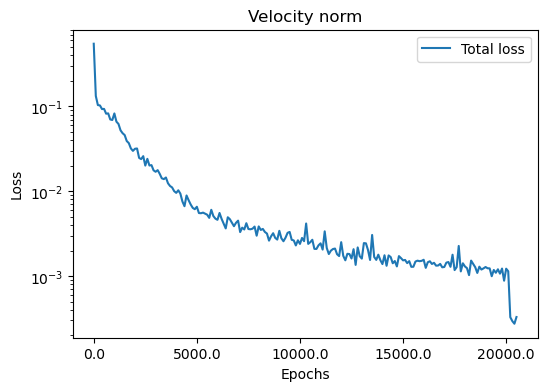

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


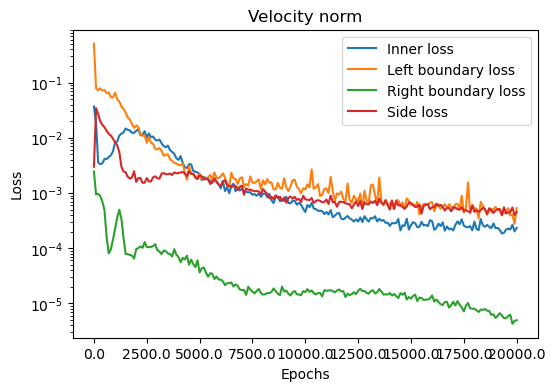

In [76]:
# vykresleni vyvoje ztraty
plot_context = utils.PlotContext(
    u_bounds=domain_ctx.u_bounds,
    l_bounds=domain_ctx.l_bounds,
    figsize=(25,3.85),
    patches=None,
    device=device,
    vmin=0.0,
    vmax=0.4,
    N=100,
    titles=['Velocity norm'],
    function_names=['u'],
    x_label='Epochs',
    y_label='Loss'
)

utils.plot_loss_values({'Total loss': total_loss_values}, plot_context)
utils.plot_loss_values({'Inner loss': component_loss_values[0],
                        'Left boundary loss': component_loss_values[1],
                        'Right boundary loss': component_loss_values[2],
                        'Side loss': component_loss_values[3]}, plot_context)

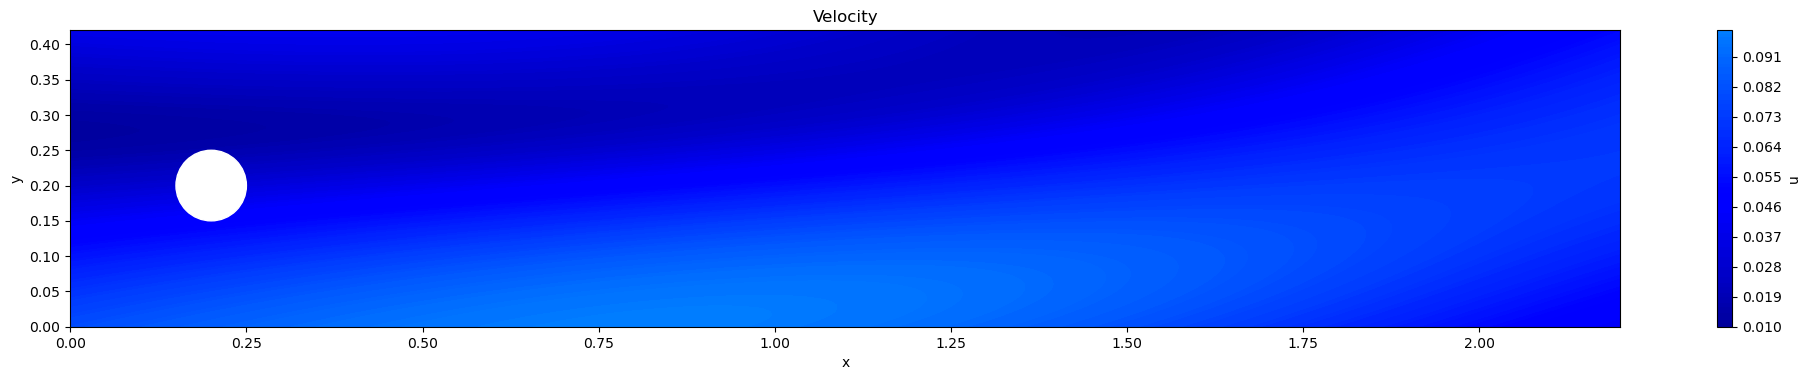

In [86]:
# vykresleni rychlosti kapaliny
plot_context.patches = [plt.Circle((0.2, 0.2), 0.05, color="white", zorder=10)]
plot_context.titles = ['Velocity']
plot_context.function_names = ['u']
plot_context.x_label = 'x'
plot_context.y_label = 'y'

def u(x: torch.Tensor): 
    x.requires_grad_(True)
    psi = model_stream(x)[:, :-1]
    psi_grad = grad(psi, x, torch.ones_like(psi), create_graph=False)[0]
    
    return torch.norm(psi_grad, dim=1, p=2)

utils.plot_function_on_2d_cube([u], plot_context)